In [1]:
import tensorflow as tf
config = tf.ConfigProto(allow_soft_placement=True) 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dty

In [2]:
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cv2

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [3]:
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/trained_weights_final.h5', #指定YOLO訓練完成權重檔路徑及名稱
        "anchors_path": 'model_data/yolo_anchors.txt', #指定錨點定義檔路徑及名稱
        "classes_path": 'model_data/my_classes.txt', #指定自定義標籤檔路徑及名稱
        "score" : 0.8, #最低置信度門檻(0.01~0.99)
        "iou" : 0.8, #重疊區比例(0.01~1.0)
        "model_image_size" : (416, 416), #影像尺寸
        "gpu_num" : 1, #使用GPU數量
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

In [5]:
yolo=YOLO() #進行YOLO初始化

model_data/trained_weights_final.h5 model, anchors, and classes loaded.


In [6]:
if __name__ == '__main__':
    t0 = timer()
    path ='VOC2007//JPEGImages' #指定待測影像檔案路徑及名稱
    listimg = os.listdir(path) #list
     
    t1 = timer()
    for i in listimg:
        img = cv2.imread(path+"//"+i)#開啟待推論影像
        img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #轉換RGB
        print(i)
        
        t2 = timer()
        image = Image.fromarray(img_cvt) #轉換格式
        r_image = yolo.detect_image(image) #進行推論
        t3 = timer()            
        #r_image.show() #顯示有標示物件框的結果影像
        
        image.save("test_save//"+i , quality=100) #儲存圖片
        
        print('Yolo inital: %f sec' %(t1-t0)) #計算及顯示YOLO初始化時間
        print('Image load: %f sec' %(t2-t1)) #計算及顯示影像載入時間
        print('Detect object: %f sec\n' %(t3-t2)) #計算偵測物件時間

    yolo.close_session() #結束YOLO工作

00001.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (125, 132) (311, 246)
4.6576515
Yolo inital: 0.080184 sec
Image load: 0.066236 sec
Detect object: 4.692238 sec

00002.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (200, 111) (416, 301)
kangaroo 0.87 (144, 105) (416, 298)
0.12220190000000031
Yolo inital: 0.080184 sec
Image load: 4.908888 sec
Detect object: 0.124411 sec

00003.jpg
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.85 (89, 74) (445, 253)
kangaroo 0.95 (107, 4) (424, 288)
kangaroo 0.96 (254, 0) (460, 242)
0.11078900000000047
Yolo inital: 0.080184 sec
Image load: 5.044596 sec
Detect object: 0.111312 sec

00004.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.85 (36, 97) (322, 195)
kangaroo 0.96 (41, 81) (288, 216)
0.10915359999999996
Yolo inital: 0.080184 sec
Image load: 5.160384 sec
Detect object: 0.109640 sec

00005.jpg
(416, 416, 3)
Found 0 boxes for img
0.10823379999999982
Yolo inital: 0.080184 sec
Image load: 5.280160 sec
Detect object: 0.109999 sec

00

Found 1 boxes for img
kangaroo 0.97 (268, 183) (472, 385)
0.10936050000000108
Yolo inital: 0.080184 sec
Image load: 9.740943 sec
Detect object: 0.110456 sec

00046.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (290, 129) (570, 324)
0.10806640000000023
Yolo inital: 0.080184 sec
Image load: 9.858797 sec
Detect object: 0.108729 sec

00047.jpg
(416, 416, 3)
Found 0 boxes for img
0.1067961000000004
Yolo inital: 0.080184 sec
Image load: 9.980599 sec
Detect object: 0.107256 sec

00048.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (402, 174) (544, 253)
0.10818980000000167
Yolo inital: 0.080184 sec
Image load: 10.094584 sec
Detect object: 0.108675 sec

00049.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.94 (0, 76) (352, 400)
kangaroo 0.99 (324, 109) (571, 413)
0.1102527999999996
Yolo inital: 0.080184 sec
Image load: 10.212287 sec
Detect object: 0.111159 sec

00050.jpg
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.86 (126, 147) (545, 600)
kangaroo 0.93 (116, 293) (594, 535)


Found 1 boxes for img
raccoon 0.92 (105, 46) (271, 320)
0.10847300000000004
Yolo inital: 0.080184 sec
Image load: 14.605650 sec
Detect object: 0.109117 sec

00093.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (453, 0) (808, 442)
0.10983559999999848
Yolo inital: 0.080184 sec
Image load: 14.728788 sec
Detect object: 0.111280 sec

00094.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (158, 0) (354, 400)
0.10833760000000048
Yolo inital: 0.080184 sec
Image load: 14.848469 sec
Detect object: 0.109091 sec

00095.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (380, 136) (605, 343)
0.10845909999999925
Yolo inital: 0.080184 sec
Image load: 14.972600 sec
Detect object: 0.109105 sec

00096.jpg
(416, 416, 3)
Found 0 boxes for img
0.11120700000000028
Yolo inital: 0.080184 sec
Image load: 15.091858 sec
Detect object: 0.113748 sec

00097.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.81 (8, 117) (894, 571)
kangaroo 0.83 (183, 134) (737, 529)
0.11934339999999999
Yolo inital: 0.

Found 4 boxes for img
kangaroo 0.81 (506, 267) (942, 637)
kangaroo 0.89 (459, 291) (974, 646)
kangaroo 0.94 (438, 255) (924, 683)
kangaroo 0.95 (489, 193) (883, 683)
0.1167484000000023
Yolo inital: 0.080184 sec
Image load: 20.338154 sec
Detect object: 0.118441 sec

00144.jpg
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.87 (100, 63) (624, 527)
kangaroo 0.91 (192, 35) (583, 575)
kangaroo 0.95 (111, 120) (655, 502)
kangaroo 0.97 (123, 0) (601, 600)
0.11545380000000094
Yolo inital: 0.080184 sec
Image load: 20.470621 sec
Detect object: 0.116857 sec

00145.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (237, 7) (370, 333)
kangaroo 0.99 (215, 67) (400, 306)
0.10923739999999782
Yolo inital: 0.080184 sec
Image load: 20.599811 sec
Detect object: 0.109822 sec

00146.jpg
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.84 (359, 82) (540, 403)
kangaroo 0.92 (86, 133) (392, 389)
kangaroo 0.96 (346, 62) (521, 427)
0.11144630000000078
Yolo inital: 0.080184 sec
Image load: 20.715730 sec
Detect o

Found 0 boxes for img
0.11095710000000025
Yolo inital: 0.080184 sec
Image load: 26.035511 sec
Detect object: 0.114070 sec

raccoon-101.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.81 (85, 24) (394, 390)
raccoon 0.97 (66, 75) (456, 336)
0.11008880000000332
Yolo inital: 0.080184 sec
Image load: 26.177259 sec
Detect object: 0.111062 sec

raccoon-102.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 12) (146, 143)
0.11192489999999822
Yolo inital: 0.080184 sec
Image load: 26.303911 sec
Detect object: 0.112503 sec

raccoon-103.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.98 (0, 29) (480, 582)
raccoon 0.99 (109, 65) (466, 508)
raccoon 1.00 (60, 108) (480, 501)
0.12678310000000081
Yolo inital: 0.080184 sec
Image load: 26.554856 sec
Detect object: 0.129829 sec

raccoon-104.jpg
(416, 416, 3)
Found 0 boxes for img
0.10543880000000172
Yolo inital: 0.080184 sec
Image load: 26.704972 sec
Detect object: 0.106072 sec

raccoon-105.jpg
(416, 416, 3)
Found 5 boxes for img
raccoon 0.93 (9

Found 0 boxes for img
0.10542949999999962
Yolo inital: 0.080184 sec
Image load: 30.982562 sec
Detect object: 0.105983 sec

raccoon-135.jpg
(416, 416, 3)
Found 4 boxes for img
raccoon 0.82 (133, 5) (640, 412)
raccoon 0.98 (136, 15) (591, 348)
raccoon 0.99 (4, 8) (640, 392)
raccoon 1.00 (76, 38) (640, 360)
0.11244370000000004
Yolo inital: 0.080184 sec
Image load: 31.095010 sec
Detect object: 0.113309 sec

raccoon-136.jpg
(416, 416, 3)
Found 0 boxes for img
0.10554799999999886
Yolo inital: 0.080184 sec
Image load: 31.223366 sec
Detect object: 0.106039 sec

raccoon-137.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.91 (106, 0) (297, 240)
raccoon 0.99 (10, 0) (320, 240)
raccoon 1.00 (53, 0) (314, 240)
0.10950750000000298
Yolo inital: 0.080184 sec
Image load: 31.332737 sec
Detect object: 0.109881 sec

raccoon-138.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.80 (62, 62) (204, 157)
raccoon 0.81 (59, 55) (229, 146)
raccoon 0.92 (57, 51) (210, 153)
0.12292140000000273
Yolo inital: 0.0801

Found 0 boxes for img
0.11367680000000036
Yolo inital: 0.080184 sec
Image load: 35.851965 sec
Detect object: 0.114834 sec

raccoon-169.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.92 (128, 26) (613, 383)
raccoon 0.95 (208, 21) (594, 399)
raccoon 0.97 (243, 0) (559, 409)
0.11303540000000112
Yolo inital: 0.080184 sec
Image load: 35.995048 sec
Detect object: 0.113635 sec

raccoon-17.jpg
(416, 416, 3)
Found 0 boxes for img
0.10526660000000021
Yolo inital: 0.080184 sec
Image load: 36.125149 sec
Detect object: 0.105795 sec

raccoon-170.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.99 (89, 35) (236, 158)
raccoon 1.00 (47, 43) (259, 152)
0.10809139999999928
Yolo inital: 0.080184 sec
Image load: 36.241759 sec
Detect object: 0.108578 sec

raccoon-171.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.89 (121, 29) (175, 114)
raccoon 0.95 (113, 23) (181, 110)
0.10898710000000023
Yolo inital: 0.080184 sec
Image load: 36.353392 sec
Detect object: 0.109387 sec

raccoon-172.jpg
(416, 416, 3)
F

Found 0 boxes for img
0.10547000000000395
Yolo inital: 0.080184 sec
Image load: 41.603998 sec
Detect object: 0.105924 sec

raccoon-25.jpg
(416, 416, 3)
Found 0 boxes for img
0.10759469999999993
Yolo inital: 0.080184 sec
Image load: 41.718750 sec
Detect object: 0.108722 sec

raccoon-26.jpg
(416, 416, 3)
Found 4 boxes for img
raccoon 0.84 (138, 0) (306, 374)
raccoon 0.95 (50, 24) (306, 339)
raccoon 0.97 (146, 3) (283, 335)
raccoon 1.00 (124, 6) (305, 355)
0.11223280000000102
Yolo inital: 0.080184 sec
Image load: 41.833799 sec
Detect object: 0.112816 sec

raccoon-27.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 25) (602, 379)
0.11279420000000329
Yolo inital: 0.080184 sec
Image load: 41.968080 sec
Detect object: 0.113399 sec

raccoon-28.jpg
(416, 416, 3)
Found 4 boxes for img
raccoon 0.92 (145, 21) (602, 452)
raccoon 0.94 (0, 12) (602, 452)
raccoon 0.98 (162, 79) (597, 435)
raccoon 1.00 (89, 69) (602, 440)
0.1133319000000057
Yolo inital: 0.080184 sec
Image load: 42.090764 sec
De

Found 4 boxes for img
raccoon 0.85 (0, 35) (199, 211)
raccoon 0.88 (4, 13) (208, 187)
raccoon 1.00 (0, 0) (179, 225)
raccoon 1.00 (0, 0) (207, 200)
0.11405689999999424
Yolo inital: 0.080184 sec
Image load: 46.338699 sec
Detect object: 0.114597 sec

raccoon-59.jpg
(416, 416, 3)
Found 7 boxes for img
raccoon 0.93 (3, 0) (574, 598)
raccoon 0.97 (33, 6) (412, 424)
raccoon 0.98 (0, 48) (584, 455)
raccoon 0.98 (0, 67) (513, 503)
raccoon 0.99 (32, 40) (469, 391)
raccoon 1.00 (0, 16) (470, 465)
raccoon 1.00 (0, 76) (523, 404)
0.11835419999999885
Yolo inital: 0.080184 sec
Image load: 46.470550 sec
Detect object: 0.119376 sec

raccoon-6.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (8, 44) (271, 331)
0.1105905000000007
Yolo inital: 0.080184 sec
Image load: 46.607887 sec
Detect object: 0.111305 sec

raccoon-60.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (60, 40) (216, 114)
0.10724809999999962
Yolo inital: 0.080184 sec
Image load: 46.723187 sec
Detect object: 0.107697 sec

raccoon-

Found 3 boxes for img
raccoon 1.00 (0, 12) (347, 433)
raccoon 1.00 (0, 2) (347, 482)
raccoon 1.00 (13, 6) (347, 438)
0.11105220000000315
Yolo inital: 0.080184 sec
Image load: 51.187358 sec
Detect object: 0.111667 sec

raccoon-90.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.93 (116, 58) (593, 426)
raccoon 1.00 (62, 79) (586, 426)
0.10967490000000168
Yolo inital: 0.080184 sec
Image load: 51.316091 sec
Detect object: 0.110513 sec

raccoon-91.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.95 (38, 0) (231, 314)
raccoon 1.00 (25, 1) (210, 308)
0.10936379999999701
Yolo inital: 0.080184 sec
Image load: 51.432518 sec
Detect object: 0.110039 sec

raccoon-92.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.95 (20, 61) (918, 570)
raccoon 0.99 (61, 73) (752, 544)
0.11411599999999567
Yolo inital: 0.080184 sec
Image load: 51.566598 sec
Detect object: 0.116238 sec

raccoon-93.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.91 (55, 25) (245, 180)
raccoon 0.97 (101, 17) (223, 191)
0.109178599

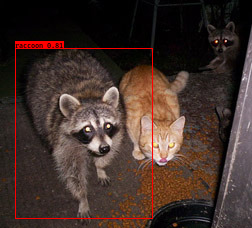

In [7]:
r_image